Performance Summary:
                   avg_pnl  median_pnl  win_rate_pct
classification                                     
Extreme Fear    34.537862         0.0     37.060748
Extreme Greed   67.892861         0.0     46.494299
Fear            54.290400         0.0     42.076750
Greed           42.743559         0.0     38.482794
Neutral         34.307718         0.0     39.699093

Behavior Summary:
                 trade_count  avg_trade_size_usd  median_trade_size_usd
classification                                                        
Extreme Fear          21400         5349.731843                766.150
Extreme Greed         39992         3112.251565                500.050
Fear                  61837         7816.109931                735.960
Greed                 50303         5736.884375                555.000
Neutral               37686         4782.732661                547.655

Buy vs Sell Ratio (%):
 Side                  BUY       SELL
classification                     

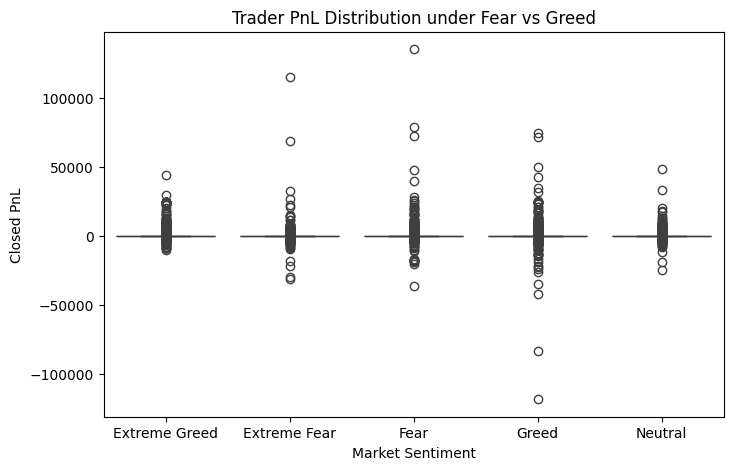

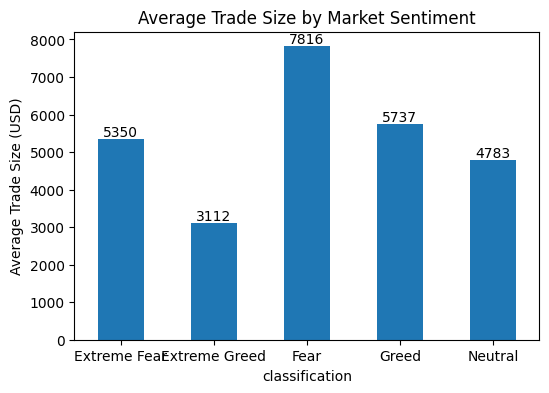

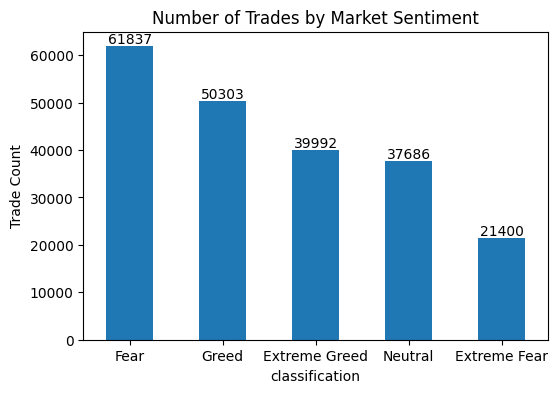

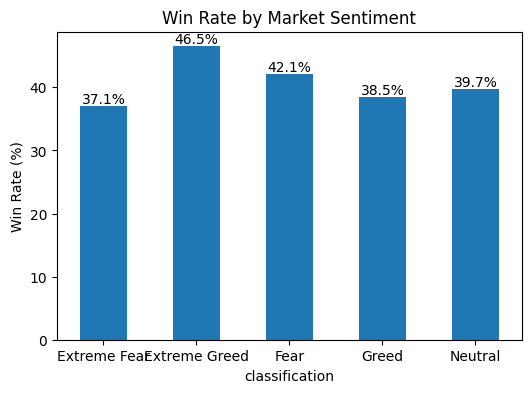

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# ===============================
# 1. LOAD DATA
# ===============================
trades_df = pd.read_csv(r"S:\Black Pearl\Language\Projects(github)\trader-sentiment-analysis\historical_data.csv")
sentiment_df = pd.read_csv(r"S:\Black Pearl\Language\Projects(github)\trader-sentiment-analysis\fear_greed_index.csv")

# ===============================
# 2. CLEAN SENTIMENT DATA
# ===============================
sentiment_df['date'] = pd.to_datetime(sentiment_df['date'])
sentiment_clean = sentiment_df[['date', 'classification']]

# ===============================
# 3. CLEAN TRADER DATA
# ===============================
trades_df['Timestamp IST'] = pd.to_datetime(
    trades_df['Timestamp IST'],
    format='mixed',
    dayfirst=True,
    errors='coerce'
)

# Drop invalid timestamps
trades_df = trades_df.dropna(subset=['Timestamp IST'])

# Extract date for joining
trades_df['date'] = pd.to_datetime(trades_df['Timestamp IST'].dt.date)

# Select relevant columns
trades_clean = trades_df[[
    'Account',
    'Coin',
    'Side',
    'Size USD',
    'Closed PnL',
    'date'
]].rename(columns={
    'Size USD': 'size_usd',
    'Closed PnL': 'closed_pnl'
})

# ===============================
# 4. MERGE DATASETS
# ===============================
merged_df = pd.merge(
    trades_clean,
    sentiment_clean,
    on='date',
    how='left'
)

# Drop rows without sentiment
merged_df = merged_df.dropna(subset=['classification'])

# ===============================
# 5. ANALYSIS (NUMERIC SUMMARIES)
# ===============================
merged_df['is_profitable'] = merged_df['closed_pnl'] > 0

performance_summary = merged_df.groupby('classification').agg(
    avg_pnl=('closed_pnl', 'mean'),
    median_pnl=('closed_pnl', 'median'),
    win_rate_pct=('is_profitable', 'mean')
)
performance_summary['win_rate_pct'] *= 100

behavior_summary = merged_df.groupby('classification').agg(
    trade_count=('closed_pnl', 'count'),
    avg_trade_size_usd=('size_usd', 'mean'),
    median_trade_size_usd=('size_usd', 'median')
)

buy_sell_ratio = pd.crosstab(
    merged_df['classification'],
    merged_df['Side'],
    normalize='index'
) * 100

print("Performance Summary:\n", performance_summary)
print("\nBehavior Summary:\n", behavior_summary)
print("\nBuy vs Sell Ratio (%):\n", buy_sell_ratio)

# ===============================
# 6. VISUALIZATIONS
# ===============================

# --- PnL Distribution ---
plt.figure(figsize=(8,5))
sns.boxplot(data=merged_df, x='classification', y='closed_pnl')
plt.title("Trader PnL Distribution under Fear vs Greed")
plt.xlabel("Market Sentiment")
plt.ylabel("Closed PnL")
plt.show()

# --- Average Trade Size ---
avg_trade_size = merged_df.groupby('classification')['size_usd'].mean()
ax = avg_trade_size.plot(kind='bar', figsize=(6,4))
plt.title("Average Trade Size by Market Sentiment")
plt.ylabel("Average Trade Size (USD)")
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.0f}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom')
plt.show()

# --- Trade Count ---
trade_counts = merged_df['classification'].value_counts()
ax = trade_counts.plot(kind='bar', figsize=(6,4))
plt.title("Number of Trades by Market Sentiment")
plt.ylabel("Trade Count")
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f"{int(p.get_height())}",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom')
plt.show()

# --- Win Rate ---
win_rate_plot = merged_df.groupby('classification')['is_profitable'].mean() * 100
ax = win_rate_plot.plot(kind='bar', figsize=(6,4))
plt.title("Win Rate by Market Sentiment")
plt.ylabel("Win Rate (%)")
plt.xticks(rotation=0)

for p in ax.patches:
    ax.annotate(f"{p.get_height():.1f}%",
                (p.get_x() + p.get_width()/2, p.get_height()),
                ha='center', va='bottom')
plt.show()
